<a href="https://colab.research.google.com/github/mjgpinheiro/AI-Strategies-StockMarket/blob/main/hot_potato2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Agent,Role_t0,EntryPrice,I,S,Notes
0,a,a.0 MarketBuy,9.11,1000,-9110.0,Aggressive buy crossing to ask
1,b,b.0 LimitSell,9.11,-1000,9110.0,Passive sell at ask (maker)
2,c,c.0 MarketSell,9.10,-1000,9100.0,Aggressive sell hitting bid
3,d,d.0 LimitBuy,9.10,1000,-9100.0,Passive buy at bid (maker)


,t_sec,agent,action,side,price,qty,P_or_A,Exit?,QueuePosOnExit,isSellAtAsk,isBuyAtAsk,HP_matchRow,HP_flag,RoundTrip_PnL
0,0.0,a,MarketBuy,ask,9.11,1800,A,,NaN,False,True,,0,
1,0.1,b,MarketSell,ask,9.11,1000,A,,NaN,True,False,2,1,0.0
2,2.0,b,MarketBuy,ask,9.11,1000,A,Y,7.0,False,True,,0,
3,8.0,a,LimitAddAsk,ask,9.11,5000,P,,NaN,False,False,,0,
4,8.3,a,Cancel,ask,9.11,5000,P,,NaN,False,False,,0,
5,8.5,a,MarketBuy,ask,9.11,200,A,Y,25.0,False,True,,0,
6,9.0,d,LimitAddAsk,ask,9.11,300,P,,NaN,False,False,,0,
7,10.0,d,Execute,ask,9.11,300,P,Y,1.0,False,False,,0,


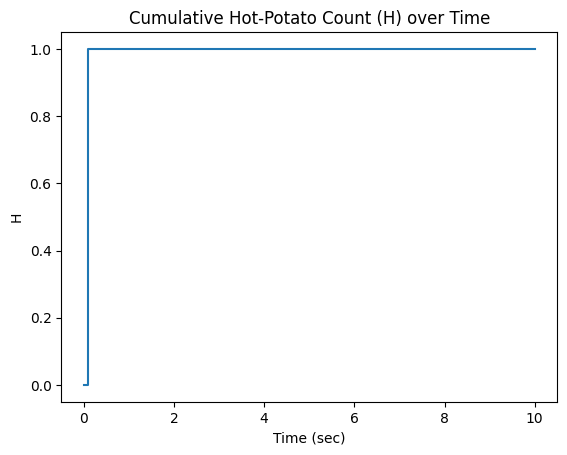

/tmp/ipython-input-4042525694.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = exits.groupby("qbin")["is_aggr"].mean().reset_index()


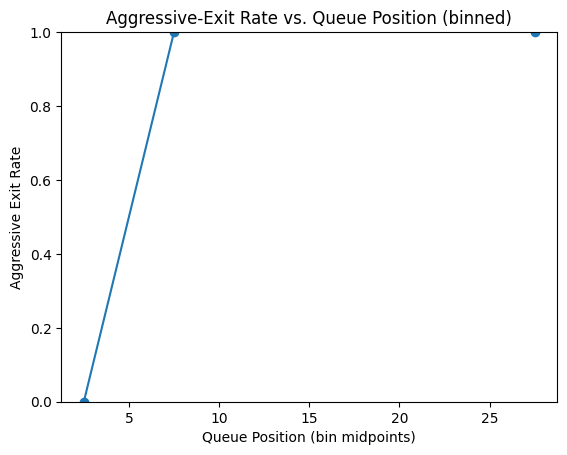

In [ ]:
# Phase 1 — Pencil Sketch (Single Tick, 4 Agents) — Pre-seeded Demo + Spoof-like
import pandas as pd, numpy as np, matplotlib.pyplot as plt, io
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
try:
    from google.colab import files
except Exception:
    files = None

# ----------------- Config -----------------
p_b = 9.10          # Best Bid
p_a = 9.11          # Best Ask
tau_sec = 5         # τ window (seconds) for hot-potato detection
pd.set_option("display.width", 140)
display(HTML(f"<h3>Config → Bid={p_b}, Ask={p_a}, τ={tau_sec}s</h3>"))

# ----------------- Agents at t0 -----------------
agents_cols = ["Agent","Role_t0","EntryPrice","I","S","Notes"]
agents_df = pd.DataFrame([
    ["a","a.0 MarketBuy",   p_a,  1000, -p_a*1000, "Aggressive buy crossing to ask"],
    ["b","b.0 LimitSell",   p_a, -1000,  p_a*1000, "Passive sell at ask (maker)"],
    ["c","c.0 MarketSell",  p_b, -1000,  p_b*1000, "Aggressive sell hitting bid"],
    ["d","d.0 LimitBuy",    p_b,  1000, -p_b*1000, "Passive buy at bid (maker)"],
], columns=agents_cols)
display(HTML("<h3>Agents_t0</h3>")); display(agents_df)

# ----------------- Helpers -----------------
event_cols = [
    "t_sec","agent","action","side","price","qty",
    "P_or_A","Exit?","QueuePosOnExit",
    "isSellAtAsk","isBuyAtAsk","HP_matchRow","HP_flag","RoundTrip_PnL"
]

def compute_derived(df, p_a, tau_sec):
    if df.empty:
        return df.copy(), 0, np.nan, 0.0
    out = df.copy()
    out["isSellAtAsk"] = (out["action"].eq("MarketSell")) & (out["price"].astype(float) == float(p_a))
    out["isBuyAtAsk"]  = (out["action"].eq("MarketBuy"))  & (out["price"].astype(float) == float(p_a))
    out["HP_matchRow"] = ""
    out["HP_flag"] = 0
    out["RoundTrip_PnL"] = ""

    # For each Sell@Ask row, find earliest Buy@Ask by same agent within τ and same qty
    for i,row in out[out["isSellAtAsk"]].iterrows():
        agent_i, t0, q0 = row["agent"], float(row["t_sec"]), float(row["qty"])
        cand = out[
            (out.index >= i) &
            (out["agent"] == agent_i) &
            (out["isBuyAtAsk"]) &
            (out["t_sec"].astype(float) >= t0) &
            (out["t_sec"].astype(float) <= t0 + float(tau_sec)) &
            (out["qty"].astype(float) == q0)
        ]
        if len(cand) > 0:
            j = cand.index[0]
            out.at[i,"HP_matchRow"] = int(j)
            out.at[i,"HP_flag"] = 1
            out.at[i,"RoundTrip_PnL"] = 0.0  # same price/qty → 0 by construction

    H = int(out["HP_flag"].sum())
    qpos_vals = pd.to_numeric(out.loc[out["Exit?"].astype(str).str.upper().eq("Y"), "QueuePosOnExit"], errors="coerce")
    avg_qpos = float(qpos_vals.mean()) if qpos_vals.notna().any() else np.nan
    total_rtpnl = pd.to_numeric(out["RoundTrip_PnL"], errors="coerce").fillna(0).sum()
    return out, H, avg_qpos, total_rtpnl

def plot_charts(df):
    # Chart 1: cumulative H over time
    hp_times = df.loc[df["HP_flag"]==1, "t_sec"].astype(float).sort_values().values
    times = np.sort(df["t_sec"].astype(float).unique())
    cumH, count, idx = [], 0, 0
    for t in times:
        while idx < len(hp_times) and hp_times[idx] <= t:
            count += 1; idx += 1
        cumH.append(count)
    plt.figure(); plt.step(times, cumH, where="post")
    plt.title("Cumulative Hot-Potato Count (H) over Time")
    plt.xlabel("Time (sec)"); plt.ylabel("H"); plt.show()

    # Chart 2: aggressive-exit rate vs queue position
    exits = df[df["Exit?"].astype(str).str.upper().eq("Y")].copy()
    if not exits.empty:
        exits["QueuePosOnExit"] = pd.to_numeric(exits["QueuePosOnExit"], errors="coerce")
        exits = exits.dropna(subset=["QueuePosOnExit"])
        if not exits.empty:
            exits["is_aggr"] = exits["P_or_A"].astype(str).str.upper().eq("A").astype(int)
            bins = np.arange(0, max(6, int(exits["QueuePosOnExit"].max())+6), 5)
            exits["qbin"] = pd.cut(exits["QueuePosOnExit"], bins=bins, right=False)
            grp = exits.groupby("qbin")["is_aggr"].mean().reset_index()
            x = grp["qbin"].apply(lambda iv: (iv.left + iv.right)/2 if pd.notna(iv) else np.nan).values
            y = grp["is_aggr"].values
            plt.figure(); plt.plot(x, y, marker="o")
            plt.title("Aggressive-Exit Rate vs. Queue Position (binned)")
            plt.xlabel("Queue Position (bin midpoints)"); plt.ylabel("Aggressive Exit Rate"); plt.ylim(0,1); plt.show()

# ----------------- Pre-seeded events -----------------
# 1) Hot-potato (agent b): Sell@Ask → Buy@Ask within τ
# 2) Spoof-like (agent a): LimitAddAsk (large) → Cancel → quick MarketBuy (aggressive exit)
events_df = pd.DataFrame([
    [0.0, "a", "MarketBuy",   "ask", p_a, 1800, "A", "",   None, None, None, "", 0, ""],
    [0.1, "b", "MarketSell",  "ask", p_a, 1000, "A", "",   None, None, None, "", 0, ""],  # Sell@Ask
    [2.0, "b", "MarketBuy",   "ask", p_a, 1000, "A", "Y",  7,    None, None, "", 0, ""],  # Buy@Ask → hot-potato (Exit?=Y)

    [8.0, "a", "LimitAddAsk", "ask", p_a, 5000, "P", "",   None, None, None, "", 0, ""],  # large visible ask
    [8.3, "a", "Cancel",      "ask", p_a, 5000, "P", "",   None, None, None, "", 0, ""],  # cancel it
    [8.5, "a", "MarketBuy",   "ask", p_a,  200, "A", "Y", 25,    None, None, "", 0, ""],  # flip to aggressive buy (Exit?=Y)

    [9.0, "d", "LimitAddAsk", "ask", p_a, 300,  "P", "",   None, None, None, "", 0, ""],
    [10.0,"d", "Execute",     "ask", p_a, 300,  "P", "Y",   1,   None, None, "", 0, ""],  # passive exit
], columns=event_cols)

events_df, H, avg_qpos, total_rtpnl = compute_derived(events_df, p_a, tau_sec)
display(HTML("<h3>Pre-seeded Events</h3>")); display(events_df)
display(HTML(f"<h4>Derived → H={H}, Avg QueuePosOnExit={avg_qpos}, Total RoundTrip P&L={total_rtpnl}</h4>"))
plot_charts(events_df)

# ----------------- Add More Events (form) -----------------
agent_dd = widgets.Dropdown(options=["a","b","c","d"], description="Agent:")
action_dd = widgets.Dropdown(options=["LimitAddBid","LimitAddAsk","MarketBuy","MarketSell","Cancel","Execute"], description="Action:")
side_dd   = widgets.Dropdown(options=["bid","ask",""], description="Side:")
price_tb  = widgets.FloatText(value=p_a, description="Price:")
qty_tb    = widgets.IntText(value=1000, description="Qty:")
porA_dd   = widgets.Dropdown(options=["P","A",""], description="P/A:")
exit_dd   = widgets.Dropdown(options=["","Y","N"], description="Exit?:")
qpos_tb   = widgets.IntText(value=None, description="QueuePos:")
tsec_tb   = widgets.FloatText(value=11.0, description="t_sec:")
add_btn   = widgets.Button(description="Add Event", button_style="primary")
out_area  = widgets.Output()

def add_event(_):
    global events_df, H, avg_qpos, total_rtpnl
    row = {
        "t_sec": tsec_tb.value, "agent": agent_dd.value, "action": action_dd.value, "side": side_dd.value,
        "price": price_tb.value, "qty": qty_tb.value, "P_or_A": porA_dd.value,
        "Exit?": exit_dd.value, "QueuePosOnExit": qpos_tb.value,
        "isSellAtAsk": None, "isBuyAtAsk": None, "HP_matchRow": "", "HP_flag": 0, "RoundTrip_PnL": ""
    }
    events_df = pd.concat([events_df, pd.DataFrame([row])], ignore_index=True)
    events_df, H, avg_qpos, total_rtpnl = compute_derived(events_df, p_a, tau_sec)
    with out_area:
        clear_output(wait=True)
        display(HTML("<h3>Events</h3>")); display(events_df)
        display(HTML(f"<h4>Derived → H={H}, Avg QueuePosOnExit={avg_qpos}, Total RoundTrip P&L={total_rtpnl}</h4>"))
        plot_charts(events_df)

display(HTML("<h3>Add More Events (Optional)</h3>"))
add_btn.on_click(add_event)
display(widgets.VBox([
    widgets.HBox([tsec_tb, agent_dd, action_dd]),
    widgets.HBox([side_dd, price_tb, qty_tb]),
    widgets.HBox([porA_dd, exit_dd, qpos_tb]),
    add_btn, out_area
]))

# ----------------- Save / Load CSV -----------------
download_events_btn = widgets.Button(description="Download Events CSV")
download_agents_btn = widgets.Button(description="Download Agents CSV")

def download_csv(df, fname):
    df.to_csv(fname, index=False)
    if files is not None: files.download(fname)
    else: print(f"Saved to {fname}")

def _dl_events(_): download_csv(events_df, "events_phase1.csv")
def _dl_agents(_): download_csv(agents_df, "agents_t0_phase1.csv")
download_events_btn.on_click(_dl_events); download_agents_btn.on_click(_dl_agents)

upload_events = widgets.FileUpload(accept=".csv", multiple=False, description="Upload Events CSV")
upload_agents = widgets.FileUpload(accept=".csv", multiple=False, description="Upload Agents CSV")

def _ul_events(change):
    global events_df, H, avg_qpos, total_rtpnl
    if upload_events.value:
        content = list(upload_events.value.values())[0]['content']
        events_df = pd.read_csv(io.BytesIO(content))
        events_df, H, avg_qpos, total_rtpnl = compute_derived(events_df, p_a, tau_sec)
        display(HTML("<h3>Events (uploaded)</h3>")); display(events_df)
        display(HTML(f"<h4>Derived → H={H}, Avg QueuePosOnExit={avg_qpos}, Total RoundTrip P&L={total_rtpnl}</h4>"))
        plot_charts(events_df)

def _ul_agents(change):
    global agents_df
    if upload_agents.value:
        content = list(upload_agents.value.values())[0]['content']
        agents_df = pd.read_csv(io.BytesIO(content))
        display(HTML("<h3>Agents (uploaded)</h3>")); display(agents_df)

upload_events.observe(_ul_events, names='value')
upload_agents.observe(_ul_agents, names='value')
display(HTML("<h3>Save / Load</h3>"))
display(widgets.HBox([download_events_btn, download_agents_btn]))
display(widgets.HBox([upload_events, upload_agents]))
